In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(1)

2 Physical GPUs, 2 Logical GPUs


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
# print(df.head())
# print(df.columns)




features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
print(features.head())

                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
01.01.2009 00:10:00    996.52     -8.02       1307.75
01.01.2009 00:20:00    996.57     -8.41       1309.80
01.01.2009 00:30:00    996.53     -8.51       1310.24
01.01.2009 00:40:00    996.51     -8.31       1309.19
01.01.2009 00:50:00    996.51     -8.27       1309.00


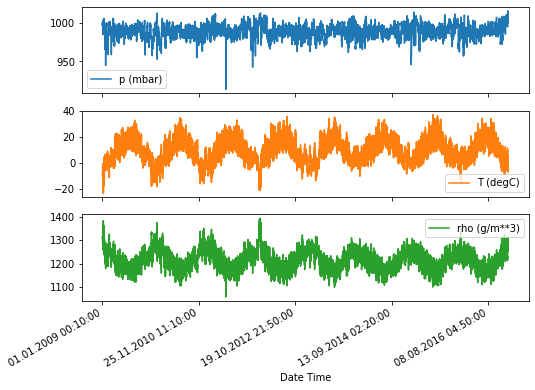

In [4]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
print(features.head())
features.plot(subplots=True)
plt.show()

In [5]:
TRAIN_SPLIT = 300000
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std
print(dataset)

[[ 0.95547359 -1.99766294  2.2350791 ]
 [ 0.96154485 -2.04281897  2.28524007]
 [ 0.95668784 -2.05439744  2.29600633]
 ...
 [ 1.35617678 -1.43494935  1.76136375]
 [ 1.35496252 -1.55883897  1.88786728]
 [ 1.35617678 -1.62715193  1.95686921]]


In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [7]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history,
                                                   future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history,
                                               future_target, STEP, single_step=True)

print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [8]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 10

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)


def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and Validation Loss')

(256, 1)
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 22ms/step - loss: 0.3152 - val_loss: 0.2658
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2652 - val_loss: 0.2398
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2621 - val_loss: 0.2465
Epoch 4/10
148/200 [=====================>........] - ETA: 0s - loss: 0.2647

KeyboardInterrupt: 

In [10]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

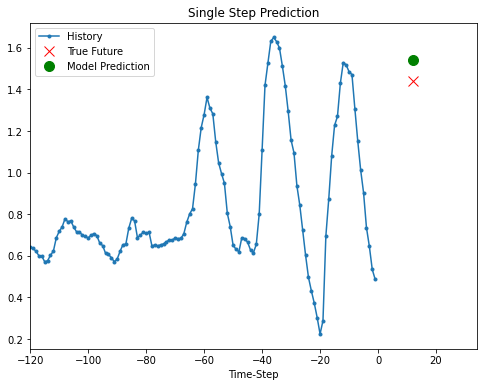

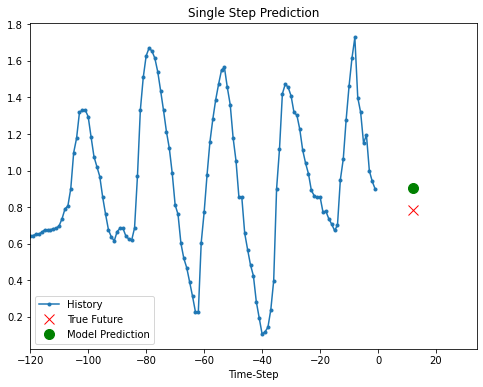

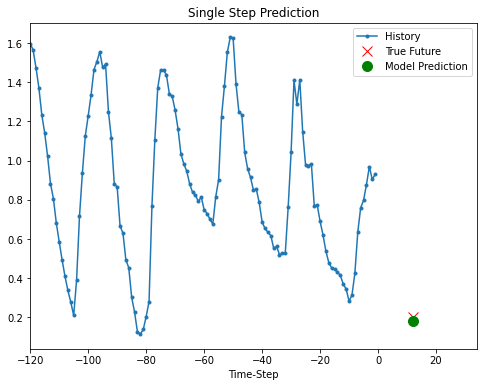

In [11]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                      single_step_model.predict(x)[0]], 12,
                     'Single Step Prediction')
    plot.show()

In [16]:
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history, future_target, STEP)

print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [20]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [22]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(120,3)))
single_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(72))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

single_step_history = single_step_model.fit(train_data_multi, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_multi,
                                            validation_steps=50)
plot_train_history(single_step_history,'multi')                                            

(256, 72)
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 14s 71ms/step - loss: 2.9643 - val_loss: 0.3200
Epoch 2/10
200/200 [==============================] - 12s 60ms/step - loss: 0.5415 - val_loss: 0.2836
Epoch 3/10
200/200 [==============================] - 12s 59ms/step - loss: 0.3804 - val_loss: 0.2870
Epoch 4/10
200/200 [==============================] - 12s 58ms/step - loss: 0.3112 - val_loss: 0.2257
Epoch 5/10
200/200 [==============================] - 12s 61ms/step - loss: 0.2180 - val_loss: 0.2239
Epoch 6/10
200/200 [==============================] - 12s 61ms/step - loss: 0.2169 - val_loss: 0.2207
Epoch 7/10
200/200 [==============================] - 12s 61ms/step - loss: 0.2064 - val_loss: 0.1985
Epoch 8/10
200/200 [==============================] - 12s 61ms/step - loss: 0.2019 - val_loss: 0.1978
Epoch 9/10
200/200 [==============================] - 12s 60ms/step - loss: 0.2036 - val_loss: 0.1911
Epoch 10/10
200/200 [========

NameError: name 'plot_train_history' is not defined

In [14]:
def multi_step_plot(history, true_future,prediction):
    plt.figure(figsize=(12,6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:,1]), label='history')
    plt.plot(np.arange(num_out)/STEP,np.array(true_future),'bo',label='True')

    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),'ro',label='prediction')

    plt.legend(loc='upper left')
    plt.show()

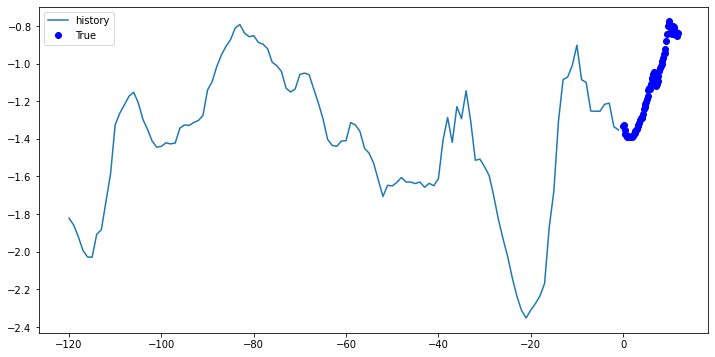

In [21]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0],y[0],np.array([0]))

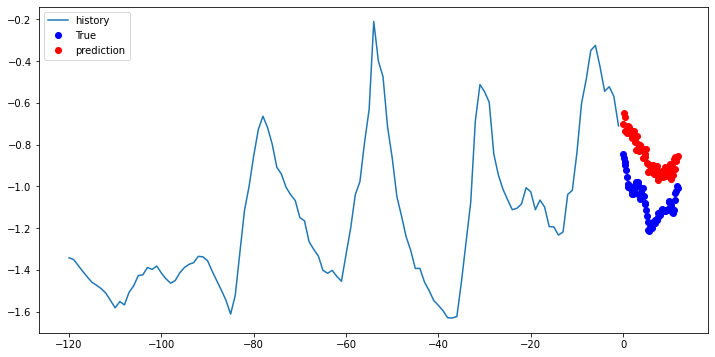

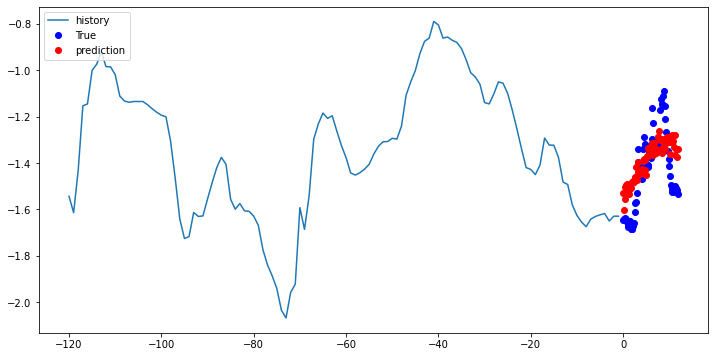

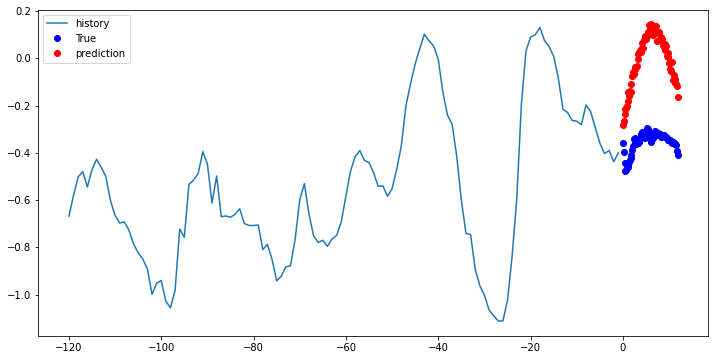

In [24]:
for x, y in train_data_multi.take(3):
    multi_step_plot(x[0],y[0],single_step_model.predict(x)[0])